<a href="https://colab.research.google.com/github/AnamikaMangore/ECG_Heartbeat-classification/blob/main/heartbeat_data_generator-MITBIH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip install wfdb

In [3]:
# prompt: code to mount drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install pyts


In [5]:
import pyts
print(pyts.__version__)


0.13.0


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField, MarkovTransitionField
from pyts.datasets import load_gunpoint
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.utils import resample
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, NearMiss
from sklearn.model_selection import train_test_split

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset,TensorDataset

In [8]:
from matplotlib import colors
from IPython import display
import os
from torch.utils.data.dataset import Dataset
from matplotlib.pyplot import imread
import glob
import os
import random
from sklearn.preprocessing import LabelEncoder

from torchvision.models import alexnet, vgg16, resnet152, resnet18, vgg19

%matplotlib inline

from torch.distributions.utils import lazy_property
import math
import h5py
from PIL import Image


import torch.nn.functional as nnf
from torch.utils.data import random_split
from torch.optim import SGD
from torch.distributions import constraints
import torchvision as torchv
import torchvision.transforms as torchvt
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [9]:
train_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/heartbeat_dataset/mitbih_train.csv',header=None)
test_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/heartbeat_dataset/mitbih_test.csv',header=None)

In [10]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
test_df.shape

(21892, 188)

In [12]:
train_df[187].value_counts()

,count
187,
0.0,72471
4.0,6431
2.0,5788
1.0,2223
3.0,641


In [13]:
test_df[187].value_counts()

,count
187,
0.0,18118
4.0,1608
2.0,1448
1.0,556
3.0,162


In [14]:
train_df[train_df[187] == 3]

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
80482,1.000000,0.899749,0.641604,0.314536,0.101504,0.107769,0.111529,0.071429,0.063910,0.058897,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
80483,0.732252,1.000000,0.983773,0.484787,0.178499,0.111562,0.081136,0.050710,0.046653,0.046653,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
80484,0.991984,1.000000,0.601202,0.280561,0.158317,0.146293,0.104208,0.090180,0.080160,0.070140,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
80485,0.778378,0.528378,0.258108,0.128378,0.000000,0.037838,0.167568,0.235135,0.227027,0.222973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
80486,1.000000,0.914931,0.531250,0.303819,0.178819,0.157986,0.128472,0.126736,0.118056,0.111111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81118,0.771529,1.000000,0.776801,0.316344,0.165202,0.124780,0.117750,0.108963,0.084359,0.091388,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
81119,0.590000,0.373333,0.283333,0.303333,0.340000,0.263333,0.136667,0.120000,0.090000,0.110000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
81120,1.000000,0.939286,0.553571,0.285714,0.166071,0.141071,0.112500,0.108929,0.094643,0.096429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
81121,1.000000,0.964981,0.778210,0.513619,0.214008,0.090791,0.112840,0.097276,0.075227,0.070039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [15]:
train_df[train_df[187] == 3].shape

(641, 188)

In [16]:
train_df.shape

(87554, 188)

In [17]:
test_df.shape

(21892, 188)

In [18]:
train_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
train_df.tail(5)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87551,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87553,0.901506,0.845886,0.800695,0.748552,0.687138,0.599073,0.512167,0.427578,0.395133,0.402086,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [20]:
# omit last column as y
x_train = train_df.iloc[:,:187]
x_test = test_df.iloc[:,:187]

In [21]:
# Load your dataset (assuming CSV with ECG signals as rows)
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/heartbeat_dataset/mitbih_train.csv")  # Replace with your actual file
X = df.values  # Convert to NumPy array



In [22]:
print("Column Names:", df.columns)

Column Names: Index(['9.779411554336547852e-01', '9.264705777168273926e-01',
       '6.813725233078002930e-01', '2.450980395078659058e-01',
       '1.544117629528045654e-01', '1.911764740943908691e-01',
       '1.519607901573181152e-01', '8.578431606292724609e-02',
       '5.882352963089942932e-02', '4.901960864663124084e-02',
       ...
       '0.000000000000000000e+00.79', '0.000000000000000000e+00.80',
       '0.000000000000000000e+00.81', '0.000000000000000000e+00.82',
       '0.000000000000000000e+00.83', '0.000000000000000000e+00.84',
       '0.000000000000000000e+00.85', '0.000000000000000000e+00.86',
       '0.000000000000000000e+00.87', '0.000000000000000000e+00.88'],
      dtype='object', length=188)


In [23]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/heartbeat_dataset/mitbih_train.csv", encoding='utf-8', engine='python')



In [24]:
# prompt: how to print the name of the column

print("Column Names:", df.columns)


Column Names: Index(['9.779411554336547852e-01', '9.264705777168273926e-01',
       '6.813725233078002930e-01', '2.450980395078659058e-01',
       '1.544117629528045654e-01', '1.911764740943908691e-01',
       '1.519607901573181152e-01', '8.578431606292724609e-02',
       '5.882352963089942932e-02', '4.901960864663124084e-02',
       ...
       '0.000000000000000000e+00.79', '0.000000000000000000e+00.80',
       '0.000000000000000000e+00.81', '0.000000000000000000e+00.82',
       '0.000000000000000000e+00.83', '0.000000000000000000e+00.84',
       '0.000000000000000000e+00.85', '0.000000000000000000e+00.86',
       '0.000000000000000000e+00.87', '0.000000000000000000e+00.88'],
      dtype='object', length=188)


In [25]:
# prompt: wrire the code to define signals and labels

# Define signals and labels
signals = x_train.values
labels = train_df[187].values
test_signals = x_test.values
test_labels = test_df[187].values


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField
import seaborn as sns

def load_mitbih_csv():
    try:
        # Path to your dataset
        file_path = "/content/drive/MyDrive/Colab Notebooks/heartbeat_dataset/mitbih_train.csv"

        # Load the CSV file
        df = pd.read_csv(file_path, header=None)  # No header in the MIT-BIH dataset

        print("Dataset loaded successfully!")
        print("Shape of dataset:", df.shape)

        # Extract signals and labels
        X = df.iloc[:, :-1].values  # All columns except the last one (ECG signal data)
        y = df.iloc[:, -1].values   # The last column (labels)

        print("Signals shape:", X.shape)
        print("Labels shape:", y.shape)

        # Print class distribution
        unique_labels, counts = np.unique(y, return_counts=True)
        print("\nClass distribution:")
        for label, count in zip(unique_labels, counts):
            print(f"Class {label}: {count} samples")

        return X, y

    except Exception as e:
        print(f"Error loading data: {str(e)}")
        raise

# Load dataset
X, y = load_mitbih_csv()


Dataset loaded successfully!
Shape of dataset: (87554, 188)
Signals shape: (87554, 187)
Labels shape: (87554,)

Class distribution:
Class 0.0: 72471 samples
Class 1.0: 2223 samples
Class 2.0: 5788 samples
Class 3.0: 641 samples
Class 4.0: 6431 samples


Dataset loaded successfully! Shape: (87554, 188)


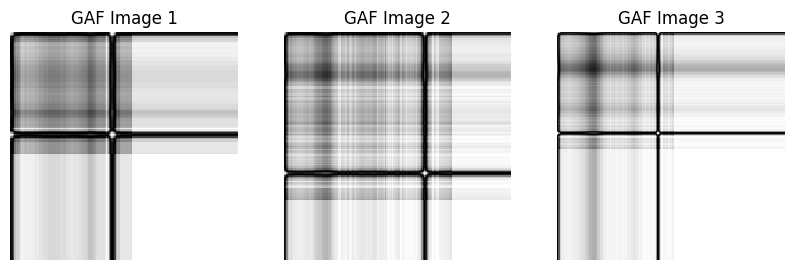

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyts.image import GramianAngularField

# Load dataset
def load_mitbih_csv():
    file_path = "/content/drive/MyDrive/Colab Notebooks/heartbeat_dataset/mitbih_train.csv"

    df = pd.read_csv(file_path, header=None)
    print("Dataset loaded successfully! Shape:", df.shape)

    # Extract signals and labels
    X = df.iloc[:, :-1].values  # ECG signals
    y = df.iloc[:, -1].values   # Labels

    return X, y

# Load data
X, y = load_mitbih_csv()

# Select a small subset to speed up GAF generation
selected_class = 0  # Normal beats (adjust as needed)
num_samples = 3  # Reduce number of samples for fast processing
selected_indices = np.where(y == selected_class)[0][:num_samples]
X_selected = X[selected_indices]

# Convert ECG signals to GAF images
gaf = GramianAngularField(method='summation', image_size=164)  # Smaller image size for speed
X_gaf = gaf.fit_transform(X_selected)  # Convert selected samples

# Plot GAF images
fig, axes = plt.subplots(1, num_samples, figsize=(10, 3))
for i in range(num_samples):
    sns.heatmap(X_gaf[i], cmap='gray', square=True, cbar=False, ax=axes[i])
    axes[i].set_title(f"GAF Image {i+1}")

    axes[i].axis('off')

plt.show()


In [28]:
# For exploratory purpose only
gasf = GramianAngularField(image_size=164, method='summation')



In [29]:
gasf

GramianAngularField(image_size=187)

In [ ]:
type(gasf)

pyts.image.gaf.GramianAngularField

In [ ]:
gasf.shape

AttributeError: 'GramianAngularField' object has no attribute 'shape'

In [ ]:
x_gasf_train = gasf.fit_transform(x_train)

In [ ]:
x_gasf_train.shape

(87554, 187, 187)

In [ ]:
x_gasf_test = gasf.transform(x_test)

In [ ]:
x_gasf_train[87553]

array([[ 0.28965888,  0.12514941,  0.00677734, ..., -0.80301273,
        -0.80301273, -0.80301273],
       [ 0.12514941, -0.04290041, -0.16091198, ..., -0.69177294,
        -0.69177294, -0.69177294],
       [ 0.00677734, -0.16091198, -0.27665898, ..., -0.60139048,
        -0.60139048, -0.60139048],
       ...,
       [-0.80301273, -0.69177294, -0.60139048, ...,  1.        ,
         1.        ,  1.        ],
       [-0.80301273, -0.69177294, -0.60139048, ...,  1.        ,
         1.        ,  1.        ],
       [-0.80301273, -0.69177294, -0.60139048, ...,  1.        ,
         1.        ,  1.        ]])

In [ ]:
x_train.values[87553, :].shape

(187,)

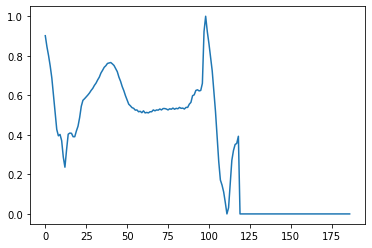

In [ ]:
# Plot 1 heartbeat
x_train.values[87553, :]
plt.plot(np.arange(187), x_train.values[87553, :])

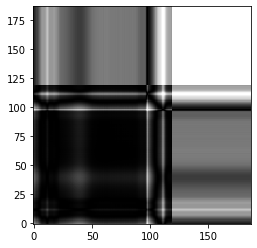

In [ ]:
# GAF for 1 heartbeat
plt.imshow(x_gasf_train[87553], cmap='gray', origin='lower')

In [ ]:
x_gasf_train[87553].shape

(187, 187)

In [ ]:
#plt.imshow(x_gasf_test[21891], cmap='gray', origin='lower')

In [ ]:
def recurrence_plot(s, eps=None, steps=None):
    result = []
    if eps==None: eps=0.1
    if steps==None: steps=10
    d = pairwise_distances(s[:, None])
    d = d / eps
    d[d > steps] = steps
    return d/5. - 1

In [ ]:
result = recurrence_plot(x_train.values[87553], steps=10)

In [ ]:
result.shape

(187, 187)

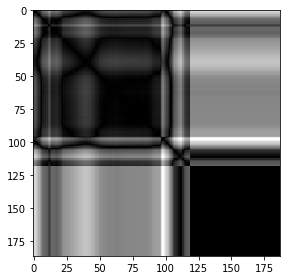

In [ ]:
# Recurrence plot for 1 heartbeat
fig = plt.figure(figsize=(15,14))
ax = fig.add_subplot(2, 3, 1)
ax.imshow(result, cmap='gray')

ValueError: Found array with dim 3. check_pairwise_arrays expected <= 2.

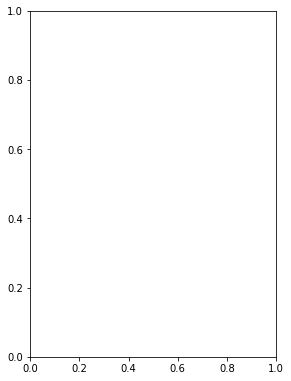

In [ ]:
# Test
fig = plt.figure(figsize=(15,14))
ax = fig.add_subplot(2, 3, 1)
ax.imshow(recurrence_plot(x_train.values[25][:, None], steps=10), cmap='gray')
d = recurrence_plot(x_train.values[25][:, None], steps=10)
scaler = MinMaxScaler((-1, 1))
x = scaler.fit_transform(d.reshape(187 * 187, 1))
x

In [ ]:
y_train = df_hb_train[187].values.astype(int)
y_test = df_hb_test[187].values.astype(int)

In [ ]:
# upsampling to reduce class imbalance
smt2 = SMOTE(sampling_strategy={1: 30000, 2: 20000, 3: 20000, 4: 10000}, n_jobs=-1, random_state=42)
x_train_2, y_train_2 = smt2.fit_sample(x_train, y_train)



In [ ]:
x_train.shape

(87554, 187)

In [ ]:
x_train_2.shape

(152471, 187)

In [ ]:
gasf = GramianAngularField(image_size=150, method='summation')
x_gasf_train_2 = gasf.fit_transform(x_train_2)
x_gasf_test_2 = gasf.transform(x_test)

In [ ]:
# create placeholders, then populate with images
with h5py.File('hb_data_mit_bih_balanced_2.hdf5', mode='w') as hdf5_file:
    hdf5_file.create_dataset("x_train", (len(x_gasf_train_2), 224, 224), np.float32)  # 224, 224 for resnet
    hdf5_file.create_dataset("y_train", (len(y_train_2),), np.int32)
    hdf5_file.create_dataset("x_test", (len(x_gasf_test_2), 224, 224), np.float32)
    hdf5_file.create_dataset("y_test", (len(y_test),), np.int32)

    transform = transforms.Compose([transforms.Resize((224, 224))])

    for i, (x, y) in enumerate(zip(x_gasf_train_2, y_train_2)):
        image = Image.fromarray(x.astype(float))
        t = np.array(transform(image))
        hdf5_file["x_train"][i, ...] = t
        hdf5_file["y_train"][i] = y

    for i, (x, y) in enumerate(zip(x_gasf_test_2, y_test)):
        image = Image.fromarray(x.astype(float))
        t = np.array(transform(image))
        hdf5_file["x_test"][i, ...] = t
        hdf5_file["y_test"][i] = y

In [ ]:
# upsampling to try with GramianAngularField method='difference'
# results are almost same for both
smt3 = SMOTE(sampling_strategy={1: 30000, 2: 20000, 3: 20000, 4: 10000}, n_jobs=-1, random_state=42)
x_train_3, y_train_3 = smt3.fit_sample(x_train, y_train)

gasf = GramianAngularField(image_size=150, method='difference')
x_gasf_train_3 = gasf.fit_transform(x_train_3)
x_gasf_test_3 = gasf.transform(x_test)

In [ ]:
with h5py.File('hb_data_mit_bih_balanced_3.hdf5', mode='w') as hdf5_file:
    hdf5_file.create_dataset("x_train", (len(x_gasf_train_3), 224, 224), np.float32)
    hdf5_file.create_dataset("y_train", (len(y_train_3),), np.int32)
    hdf5_file.create_dataset("x_test", (len(x_gasf_test_3), 224, 224), np.float32)
    hdf5_file.create_dataset("y_test", (len(y_test),), np.int32)

    transform = transforms.Compose([transforms.Resize((224, 224))])

    for i, (x, y) in enumerate(zip(x_gasf_train_3, y_train_3)):
        image = Image.fromarray(x.astype(float))
        t = np.array(transform(image))
        hdf5_file["x_train"][i, ...] = t
        hdf5_file["y_train"][i] = y

    for i, (x, y) in enumerate(zip(x_gasf_test_3, y_test)):
        image = Image.fromarray(x.astype(float))
        t = np.array(transform(image))
        hdf5_file["x_test"][i, ...] = t
        hdf5_file["y_test"][i] = y

In [ ]:
with h5py.File('hb_data_mit_bih_balanced_rp.hdf5', mode='w') as hdf5_file:
    hdf5_file.create_dataset("x_train", (len(x_train_2), 224, 224), np.float32)
    hdf5_file.create_dataset("y_train", (len(y_train_2),), np.int32)
    hdf5_file.create_dataset("x_test", (len(x_test), 224, 224), np.float32)
    hdf5_file.create_dataset("y_test", (len(y_test),), np.int32)

    transform = transforms.Compose([transforms.Resize((224, 224))])

    for i, (x, y) in enumerate(zip(x_train_2.values, y_train_2)):
        r = recurrence_plot(x, steps=10)
        image = Image.fromarray(r.astype(float))
        t = np.array(transform(image))
        hdf5_file["x_train"][i, ...] = t
        hdf5_file["y_train"][i] = y

    for i, (x, y) in enumerate(zip(x_test.values, y_test)):
        r = recurrence_plot(x, steps=10)
        image = Image.fromarray(r.astype(float))
        t = np.array(transform(image))
        hdf5_file["x_test"][i, ...] = t
        hdf5_file["y_test"][i] = y

In [ ]:
# Generating mixed hdf5: containing RP, GAF and mean of RP and GAF in 3 channels
# Previous ones were single channel images
with h5py.File('/media/asif/data/hb_data_mit_bih_balanced_mixed.hdf5', mode='w') as hdf5_file:
    hdf5_file.create_dataset("x_train", (len(x_train_3), 3, 224, 224), np.float32)
    hdf5_file.create_dataset("y_train", (len(y_train_3),), np.int32)
    hdf5_file.create_dataset("x_test", (len(x_test), 3, 224, 224), np.float32)
    hdf5_file.create_dataset("y_test", (len(y_test),), np.int32)

    transform = transforms.Compose([transforms.Resize((224, 224))])

    for i, (x1, x2, y) in enumerate(zip(x_gasf_train_3, x_train_3.values, y_train_3)):
        image = Image.fromarray(x1.astype(float))
        t = np.array(transform(image))
        r = recurrence_plot(x2, steps=10)
        image = Image.fromarray(r.astype(float))
        t2 = np.array(transform(image))
        hdf5_file["x_train"][i, 0, ...] = t
        hdf5_file["x_train"][i, 1, ...] = t2
        hdf5_file["x_train"][i, 2, ...] = (t + t2) / 2
        hdf5_file["y_train"][i] = y

    for i, (x1, x2, y) in enumerate(zip(x_gasf_test_3, x_test.values, y_test)):
        image = Image.fromarray(x1.astype(float))
        t = np.array(transform(image))
        r = recurrence_plot(x2, steps=10)
        image = Image.fromarray(r.astype(float))
        t2 = np.array(transform(image))
        hdf5_file["x_test"][i, 0, ...] = t
        hdf5_file["x_test"][i, 1, ...] = t2
        hdf5_file["x_test"][i, 2, ...] = (t + t2) / 2
        hdf5_file["y_test"][i] = y

In [ ]:
# Hearbeat values range from 0 to 1; we will divide into quantiles and see which bin each value belongs to
# and what the probability is to transfer from 1 bin to other
# i.e if 1 value is in bin 1 and the next value is in bin 5, what is the probability of transferring from
# bin 1 to 5
# correlation matrix of probabilities is markov transition field
def get_quantiles(min_value=0, max_val=1, k=10):
    c = (max_val - min_value)/k
    b = min_value + c
    d = []
    for i in range(1, k):
        d.append(b)
        b += c
    d.append(max_val)
    return d

quantiles = get_quantiles()

def value_to_quantile(x):
    for i, k in enumerate(quantiles):
        if x <= k:
            return i
    return 0

# qv_train = np.vectorize(value_to_quantile)(x_train_3.values)
# qv_test = np.vectorize(value_to_quantile)(x_test.values)

In [ ]:
def get_mtf(x, size=10):
    q = np.vectorize(value_to_quantile)(x)
    r = np.zeros((q.shape[0], q.shape[0]))
    y = np.zeros((size, size))
    for i in range(x.shape[0] - 1):
        y[q[i], q[i + 1]] += 1
    y = y / y.sum(axis=1, keepdims=True)
    y[np.isnan(y)] = 0

    for i in range(r.shape[0]):
        for j in range(r.shape[1]):
            r[i, j] = y[q[i], q[j]]
    return r / 5. - 1

In [ ]:
# MTF for 1 image
get_mtf(x_train_3.values[0])

NameError: name 'x_train_3' is not defined

In [ ]:
plt.imshow(get_mtf(x_train_3.values[0]), cmap='gray', origin='lower')

In [ ]:
np.seterr(divide='ignore', invalid='ignore')

In [ ]:
smt3 = SMOTE(sampling_strategy={1: 30000, 2: 20000, 3: 20000, 4: 10000}, n_jobs=-1, random_state=42)
x_train_3, y_train_3 = smt3.fit_sample(x_train, y_train)

In [ ]:
with h5py.File('/media/asif/data/hb_data_mit_bih_balanced_mtf.hdf5', mode='w') as hdf5_file:
    hdf5_file.create_dataset("x_train", (len(x_train_3), 224, 224), np.float32)
    hdf5_file.create_dataset("y_train", (len(y_train_3),), np.int32)
    hdf5_file.create_dataset("x_test", (len(x_test), 224, 224), np.float32)
    hdf5_file.create_dataset("y_test", (len(y_test),), np.int32)

    transform = transforms.Compose([transforms.Resize((224, 224))])

    for i, (x, y) in enumerate(zip(x_train_3.values, y_train_3)):
        mtf = get_mtf(x)
        image = Image.fromarray(mtf.astype(float))
        t = np.array(transform(image))
        hdf5_file["x_train"][i, ...] = t
        hdf5_file["y_train"][i] = y

    for i, (x, y) in enumerate(zip(x_test.values, y_test)):
        mtf = get_mtf(x)
        image = Image.fromarray(mtf.astype(float))
        t = np.array(transform(image))
        hdf5_file["x_test"][i, ...] = t
        hdf5_file["y_test"][i] = y

In [ ]:
# 3 channels, this time with GAF, RP and MTF
with h5py.File('/media/asif/data/hb_data_mit_bih_balanced_gaf_rp_mtf.hdf5', mode='w') as hdf5_file:
    hdf5_file.create_dataset("x_train", (len(x_train_3), 3, 224, 224), np.float32)
    hdf5_file.create_dataset("y_train", (len(y_train_3),), np.int32)
    hdf5_file.create_dataset("x_test", (len(x_test), 3, 224, 224), np.float32)
    hdf5_file.create_dataset("y_test", (len(y_test),), np.int32)

    transform = transforms.Compose([transforms.Resize((224, 224))])

    for i, (x1, x2, y) in enumerate(zip(x_gasf_train_3, x_train_3.values, y_train_3)):
        image = Image.fromarray(x1.astype(float))
        t = np.array(transform(image))
        r = recurrence_plot(x2, steps=10)
        mtf = get_mtf(x2)
        image = Image.fromarray(r.astype(float))
        t2 = np.array(transform(image))
        image = Image.fromarray(mtf.astype(float))
        t3 = np.array(transform(image))
        hdf5_file["x_train"][i, 0, ...] = t
        hdf5_file["x_train"][i, 1, ...] = t2
        hdf5_file["x_train"][i, 2, ...] = t3
        hdf5_file["y_train"][i] = y

    for i, (x1, x2, y) in enumerate(zip(x_gasf_test_3, x_test.values, y_test)):
        image = Image.fromarray(x1.astype(float))
        t = np.array(transform(image))
        r = recurrence_plot(x2, steps=10)
        mtf = get_mtf(x2)
        image = Image.fromarray(r.astype(float))
        t2 = np.array(transform(image))
        image = Image.fromarray(mtf.astype(float))
        t3 = np.array(transform(image))
        hdf5_file["x_test"][i, 0, ...] = t
        hdf5_file["x_test"][i, 1, ...] = t2
        hdf5_file["x_test"][i, 2, ...] = t3
        hdf5_file["y_test"][i] = y